In [1]:
# Name: Suprajaa Anbumozhi
# Student ID: 1222641

In [2]:
"""
All the necessary libraries are imported here
Prerequisite libraries to run this program
1. NLTK
2. Numpy
3. Sklearn
4. Matplotlib
5. Textblob
6. wordcloud
"""
import json
import nltk
import re
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from textblob import TextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [3]:
def reading_jsonl_file(filename):
    """
    Function that reads and return the jsonl files
    """
    tweets = []
    with open(filename, 'r') as file:
        data = list(file)

    for tweet in data:
        tweets.append(json.loads(tweet))
    
    return tweets


def reading_json_file(filename): 
    """
    Function that reads and return json files
    """
    labels = []
    with open(filename, 'r') as file:
        data = json.load(file)
    
    for k, v in data.items():
        labels.append(v)
    
    return labels

   
# Storing all training, development, testing and COVID-19 dataset
x_train_tweets = reading_jsonl_file("project-data/train.data.jsonl")
y_train_tweets = reading_json_file("project-data/train.label.json")

x_dev_tweets = reading_jsonl_file("project-data/dev.data.jsonl")
y_dev_tweets = reading_json_file("project-data/dev.label.json")

x_test_tweets = reading_jsonl_file("project-data/test.data.jsonl")

x_covid_tweets = reading_jsonl_file("project-data/covid.data.jsonl")

len(x_train_tweets), len(y_train_tweets), len(x_dev_tweets), len(y_dev_tweets), len(x_test_tweets), len(x_covid_tweets)

(4641, 4641, 580, 580, 581, 17458)

In [4]:
def tweet_texts(tweets):
    """
    Function to parse over the tweet details and returns
    1. Tweet with their replies
    2. Source tweet
    3. User unique ID
    """
    tweet_text = []
    user_ids = []
    source_tweet = []

    for threads in tweets:
        tweet_thread = []
        user_id = ""
                
        for thread in threads:
            if not user_id:
                user_id = thread['id_str']
                
            # For source tweet, "in_reply_to_status_id_str" key is null
            if not thread['in_reply_to_status_id_str']:
                source_tweet.append(thread['text'])

            tweet_thread.append(thread['text'])
            
        tweet_text.append(" ".join(tweet_thread))
        user_ids.append(user_id)
        
    return tweet_text, source_tweet, user_ids

x_train_text, x_train_source_tweet, y_train_user_ids = tweet_texts(x_train_tweets)
x_dev_text, x_dev_source_tweet, y_dev_user_ids = tweet_texts(x_dev_tweets)
x_test_text, x_test_source_tweet, y_test_user_ids = tweet_texts(x_test_tweets)
x_covid_text, x_covid_source_tweet, y_covid_user_ids = tweet_texts(x_covid_tweets)

print("Training set length {}, {}, {}".format(len(x_train_text), len(x_train_source_tweet), len(y_train_user_ids)))
print("Development set length {}, {}, {}".format(len(x_dev_text), len(x_dev_source_tweet), len(y_dev_user_ids)))
print("Test set length {}, {}, {}".format(len(x_test_text), len(x_test_source_tweet), len(y_test_user_ids)))
print("Covid set length {}, {}, {}".format(len(x_covid_text), len(x_covid_source_tweet), len(y_covid_user_ids)))

Training set length 4641, 4641, 4641
Development set length 580, 580, 580
Test set length 581, 581, 581
Covid set length 17458, 17458, 17458


In [5]:
tt = TweetTokenizer()
stopwords = set(stopwords.words("english"))

In [6]:
def tweet_tokenisation(tweet):
    """
    Function that removes all the stopwords, words that don't have alphabets
    and user tags from a tweet
    """
    processed_tweet = ""
    tokenized_tweet = tt.tokenize(tweet)
    for word in tokenized_tweet:
            word = word.lower()
            if re.search("[a-z]", word) and word not in stopwords and not word.startswith('@'):
                processed_tweet = processed_tweet + " " + word
                
    if not len(processed_tweet):
        processed_tweet = " ".join(tokenized_tweet)
        
    return processed_tweet.strip()


def preprocess_data(thread, source_tweets, labels, ids):
    """
    Converts the rumour to 1 and non-rumour to 0
    Returns
    1. Pre-processed tweets and their replies
    2. Pre-processed source tweets
    3. Json of User IDs of tweet users
    """
    x_thread = []
    x_source = []
    y = []
    user_ids = {}
    
    # For test data, there are no labels
    if not labels:
        labels = [''] * len(thread)
        
    for tweet, source_tweet, label, user in zip(thread, source_tweets, labels, ids):
        x_thread.append(tweet_tokenisation(tweet))
        x_source.append(tweet_tokenisation(source_tweet))
        
        label = 1 if label == 'rumour' else 0
        y.append(label)
        
        user_ids[user] = ""

    return x_thread, x_source, np.array(y), user_ids

x_train_processed, x_train_source_processed, y_train, y_train_ids = preprocess_data(x_train_text, 
                                                                                    x_train_source_tweet, 
                                                                                    y_train_tweets, 
                                                                                    y_train_user_ids
                                                                                   )
x_dev_processed, x_dev_source_processed, y_dev, y_dev_ids = preprocess_data(x_dev_text, 
                                                                            x_dev_source_tweet,
                                                                            y_dev_tweets, 
                                                                            y_dev_user_ids
                                                                           )
x_test_processed, x_test_source_processed, y_test, y_test_ids = preprocess_data(x_test_text, 
                                                                                x_test_source_tweet,
                                                                                [], 
                                                                                y_test_user_ids
                                                                               )
x_covid_processed, x_covid_source_processed, y_covid, y_covid_ids = preprocess_data(x_covid_text, 
                                                                                    x_covid_source_tweet,
                                                                                    [], 
                                                                                    y_covid_user_ids
                                                                                   )

print("Training set length {}, {}, {}".format(len(x_train_processed), len(x_train_source_processed), len(y_train)))
print("Development set length {}, {}, {}".format(len(x_dev_processed), len(x_dev_source_processed), len(y_dev)))
print("Test set length {}, {}, {}".format(len(x_test_processed), len(x_test_source_processed), len(y_test)))
print("Covid set length {}, {}, {}".format(len(x_covid_processed), len(x_covid_source_processed), len(y_covid)))

Training set length 4641, 4641, 4641
Development set length 580, 580, 580
Test set length 581, 581, 581
Covid set length 17458, 17458, 17458


In [7]:
label = {
    0: "non-rumour",
    1: "rumour"
}

def update_op_json(user_ids, data):
    """
    Update the json of user ids with rumour or non-rumour
    """
    for user_id, pred in zip(user_ids, data):
        idx = pred if isinstance(pred, (int, np.integer)) else pred[0]
        user_ids[user_id] = label[idx]
        
    return user_ids

In [8]:
# Converting text into vectors of tweets with their replies
vec_thread = CountVectorizer()
x_train = vec_thread.fit_transform(x_train_processed)
x_dev = vec_thread.transform(x_dev_processed)
x_test = vec_thread.transform(x_test_processed)
x_covid = vec_thread.transform(x_covid_processed)

# Converting text into vectors of source tweets
vec_source = CountVectorizer()
x_train_source = vec_source.fit_transform(x_train_source_processed)
x_dev_source = vec_source.transform(x_dev_source_processed)
x_test_source = vec_source.transform(x_test_source_processed)
x_covid_source = vec_source.transform(x_covid_source_processed)

In [9]:
# SVM model
svm_model = svm.SVC(kernel='linear') # Linear Kernel

svm_model.fit(x_train, y_train)

# Predicting development data
y_pred_svm = svm_model.predict(x_dev)

# F1-score calculation
svm_f1 = f1_score(y_dev, y_pred_svm)
print("F1 score: {}".format(svm_f1))

F1 score: 0.6989247311827957


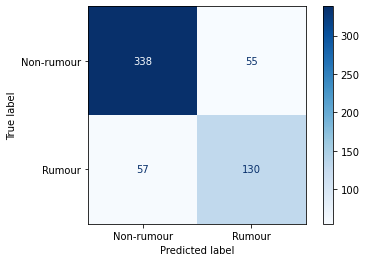

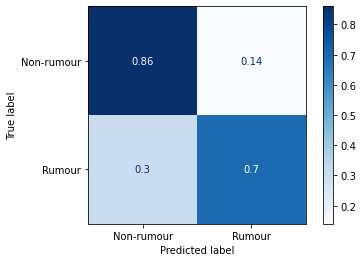

In [10]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['Non-rumour', 'Rumour']

for title, normalize in titles_options:
    disp = plot_confusion_matrix(svm_model, x_dev, y_dev,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

In [11]:
# MLP classifier for tweets with their replies

mlp = MLPClassifier(hidden_layer_sizes=30, 
                    activation='relu',
                    solver='adam', 
                    max_iter=100,
                    verbose=True,
                    learning_rate="adaptive"
                   ).fit(x_train, y_train)

# Predicting development data
y_pred_mlp = mlp.predict(x_dev)

cm_dev = confusion_matrix(y_dev, y_pred_mlp)

# F1 score calculation
f1_score_mlp = f1_score(y_dev, y_pred_mlp)

print("F1 score {}".format(f1_score_mlp))

Iteration 1, loss = 0.55132285
Iteration 2, loss = 0.31453559
Iteration 3, loss = 0.19220030
Iteration 4, loss = 0.12755248
Iteration 5, loss = 0.09219461
Iteration 6, loss = 0.07022862
Iteration 7, loss = 0.05560554
Iteration 8, loss = 0.04499210
Iteration 9, loss = 0.03728017
Iteration 10, loss = 0.03129994
Iteration 11, loss = 0.02666777
Iteration 12, loss = 0.02310715
Iteration 13, loss = 0.02011953
Iteration 14, loss = 0.01768551
Iteration 15, loss = 0.01563850
Iteration 16, loss = 0.01389647
Iteration 17, loss = 0.01245877
Iteration 18, loss = 0.01121163
Iteration 19, loss = 0.01014434
Iteration 20, loss = 0.00922175
Iteration 21, loss = 0.00840952
Iteration 22, loss = 0.00771674
Iteration 23, loss = 0.00711578
Iteration 24, loss = 0.00652997
Iteration 25, loss = 0.00601784
Iteration 26, loss = 0.00559428
Iteration 27, loss = 0.00519393
Iteration 28, loss = 0.00484042
Iteration 29, loss = 0.00452762
Iteration 30, loss = 0.00425216
Iteration 31, loss = 0.00399823
Iteration 32, los

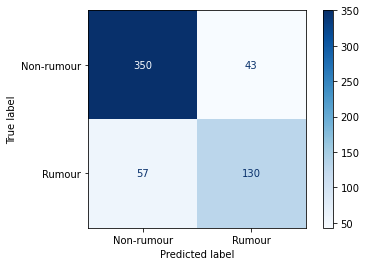

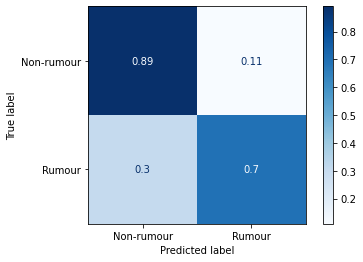

In [12]:
# Plotting Confusion matrix of development set
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlp, x_dev, y_dev,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

In [13]:
# MLP classifier for source tweets
mlp_source = MLPClassifier(hidden_layer_sizes=4, 
                    activation='relu',
                    solver='adam', 
                    max_iter=100,
                    verbose=True,
                    learning_rate="adaptive"
                   ).fit(x_train_source, y_train)

# Prediction of development data
y_dev_pred_source = mlp_source.predict(x_dev_source)

cm_dev_source = confusion_matrix(y_dev, y_dev_pred_source)

# F1 score calculation
f1_score_source = f1_score(y_dev, y_dev_pred_source)

print("Confusion matrix {}".format(cm_dev_source.ravel()))
print("F1 score {}".format(f1_score_source))

Iteration 1, loss = 0.62451363
Iteration 2, loss = 0.55806011
Iteration 3, loss = 0.49260192
Iteration 4, loss = 0.43785518
Iteration 5, loss = 0.39249840
Iteration 6, loss = 0.35485535
Iteration 7, loss = 0.32367260
Iteration 8, loss = 0.29699142
Iteration 9, loss = 0.27407570
Iteration 10, loss = 0.25395472
Iteration 11, loss = 0.23626938
Iteration 12, loss = 0.22040556
Iteration 13, loss = 0.20612142
Iteration 14, loss = 0.19331270
Iteration 15, loss = 0.18148741
Iteration 16, loss = 0.17093707
Iteration 17, loss = 0.16119963
Iteration 18, loss = 0.15227143
Iteration 19, loss = 0.14411673
Iteration 20, loss = 0.13642588
Iteration 21, loss = 0.12954527
Iteration 22, loss = 0.12301762
Iteration 23, loss = 0.11701763
Iteration 24, loss = 0.11121560
Iteration 25, loss = 0.10606451
Iteration 26, loss = 0.10106931
Iteration 27, loss = 0.09646678
Iteration 28, loss = 0.09203069
Iteration 29, loss = 0.08803586
Iteration 30, loss = 0.08418545
Iteration 31, loss = 0.08060958
Iteration 32, los

C:\anaconda\envs\keras_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
# Prediction of test data
y_test_pred_source = mlp_source.predict(x_test_source)

# Updating the json of test data user IDs
test_json = update_op_json(y_test_ids, y_test_pred_source)

print("Test data prediction {}".format(test_json))

Test data prediction {'544382249178001408': 'non-rumour', '525027317551079424': 'rumour', '544273220128739329': 'rumour', '499571799764770816': 'non-rumour', '552844104418091008': 'non-rumour', '524977651476623360': 'rumour', '544514988078280704': 'non-rumour', '524928863714168832': 'non-rumour', '544390718253699072': 'non-rumour', '580322349569994752': 'non-rumour', '544475905926524928': 'non-rumour', '544389986809036800': 'non-rumour', '498530293116968960': 'non-rumour', '498293625420148736': 'non-rumour', '552831230735962113': 'non-rumour', '553589469849583616': 'non-rumour', '544415816851021824': 'rumour', '552850116324130816': 'non-rumour', '544318036715782144': 'rumour', '524974318087061504': 'rumour', '553592195786506240': 'non-rumour', '524959778125385728': 'non-rumour', '553502311872733184': 'non-rumour', '499698366402789376': 'non-rumour', '525032872647065600': 'rumour', '553110609513177088': 'non-rumour', '544267656597995521': 'rumour', '552845393541988352': 'non-rumour', '5

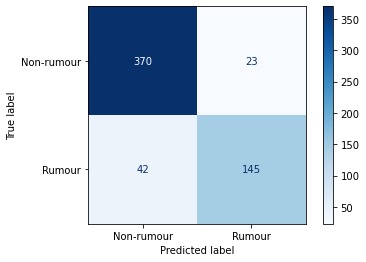

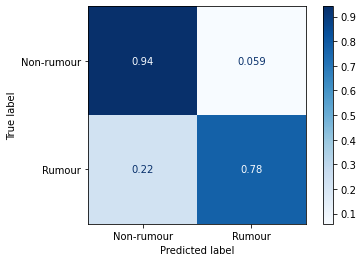

In [15]:
# Plotting the confusion matrix for source tweet MLP classifier
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlp_source, x_dev_source, y_dev,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

In [16]:
# Prediction of COVID-19 data
y_covid_pred = mlp_source.predict(x_covid_source)

# Updating covid tweets user IDs
covid_prediction = update_op_json(y_covid_ids, y_covid_pred)

In [17]:
def get_tweet_sentiment(tweet):
        '''
        Function to classify tweet sentiment using textblob
        '''
        analysis = TextBlob(tweet)
        
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

In [18]:
non_rumour_hashtags = []
rumour_hashtags = []
rumour_data = []
non_rumour_data = []
rumour_tweets_analysis = {
    'positive': 0,
    'negative': 0,
    'neutral': 0
}
non_rumour_tweets_analysis = {
    'positive': 0,
    'negative': 0,
    'neutral': 0
}

for (tweet, label) in zip(x_covid_source_processed, y_covid_pred):
    # Taking the hashtags
    hashtags = [x for x in tweet.split(' ') if x.startswith('#')]
    
    # Analysing the tweet sentiment
    analysis = get_tweet_sentiment(tweet)
    
    if label:
        rumour_tweets_analysis[analysis] += 1
        # Storing the rumour texts and hashtags
        rumour_data += tweet.split(' ')
        rumour_hashtags += hashtags
    else:
        non_rumour_tweets_analysis[analysis] += 1
        # Storing the non-rumour texts and hashtags
        non_rumour_data += tweet.split(' ')
        non_rumour_hashtags += hashtags

rumour_hashtags = Counter(rumour_hashtags)
non_rumour_hashtags = Counter(non_rumour_hashtags)

print("Rumour tweet Analysis: {}".format(rumour_tweets_analysis))
print("Non-rumour tweet Analysis: {}".format(non_rumour_tweets_analysis))
print("5 common rumour hashtag: {}".format(rumour_hashtags.most_common(5)))
print("5 common non-rumour hashtag: {}".format(non_rumour_hashtags.most_common(5)))

Rumour tweet Analysis: {'positive': 598, 'negative': 398, 'neutral': 532}
Non-rumour tweet Analysis: {'positive': 7174, 'negative': 3699, 'neutral': 5057}
5 common rumour hashtag: [('#covid19', 200), ('#coronavirus', 106), ('#breaking', 24), ('#cdnpoli', 7), ('#covidー19', 6)]
5 common non-rumour hashtag: [('#covid19', 2244), ('#coronavirus', 1079), ('#breaking', 76), ('#china', 45), ('#stayhome', 42)]


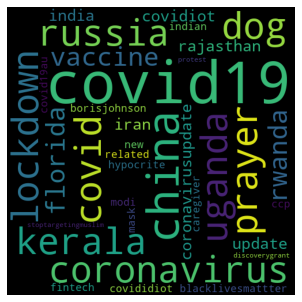

In [19]:
stopwords = set(STOPWORDS)

all_hashtags = rumour_hashtags + non_rumour_hashtags

# Plotting the WordCloud image of all hashtags
hashtags = WordCloud(width=500, 
                      height=500,
                      stopwords=stopwords,
                      background_color='black',
                      min_font_size=10
                     ).generate(" ".join(all_hashtags))
                         
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(hashtags)
plt.axis("off")
plt.tight_layout(pad=0)
  
plt.show()

In [20]:
common_hashtags = []

# Finding the common hashtags in rumour and non-rumour
for hashtag, count in rumour_hashtags.items():
    if non_rumour_hashtags.get(hashtag):
        common_hashtags.append([hashtag, count, non_rumour_hashtags[hashtag]])
        
print("Common hashtags count: {}".format(len(common_hashtags)))

Common hashtags count: 137


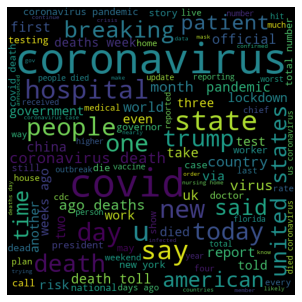

In [21]:
def remove_stopwords(dataset):
    # Removing hashtags and links
    return [data for data in dataset if not data.startswith(('#', 'https'))]

updated_rumour_data = remove_stopwords(rumour_data)

# Plotting the WordCloud image of rumour tweets
rumour_word_cloud = WordCloud(width=500, 
                      height=500,
                      stopwords=stopwords,
                      background_color='black',
                      min_font_size=10
                     ).generate(" ".join(updated_rumour_data))
                        
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(rumour_word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
  
plt.show()

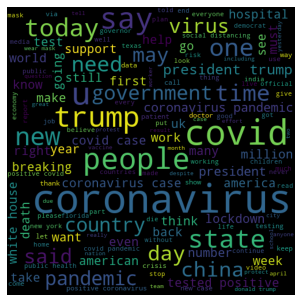

In [22]:
updated_non_rumour_data = remove_stopwords(non_rumour_data)

# Plotting the WordCloud image of non-rumour tweets
non_rumour_wordcloud = WordCloud(width=500, 
                      height=500,
                      stopwords=stopwords,
                      background_color='black',
                      min_font_size=10
                     ).generate(" ".join(updated_non_rumour_data))
  
# plot the WordCloud image                       
plt.figure(figsize = (4, 4), facecolor=None)
plt.imshow(non_rumour_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
  
plt.show()